# GFs for MNIST (Multiscale)

In [1]:
# @title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config

# import chex
config.update("jax_enable_x64", False)

import chex
import numpy as np
from functools import partial

# Plot utilities
from rbig_jax.custom_types import ImageShape
from rbig_jax.plots import plot_image_grid


KEY = jax.random.PRNGKey(123)

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import corner
from IPython.display import HTML

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext lab_black
%matplotlib inline
%load_ext autoreload
%autoreload 2

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Demo Data

In this demonstration, we will be using the "mnist" dataset.

In [3]:
import tensorflow as tf

(X_train, _), (X_test) = tf.keras.datasets.mnist.load_data()
image_shape = ImageShape(28, 28, 1)

n_init = 10_000

X_init = X_train[:n_init]

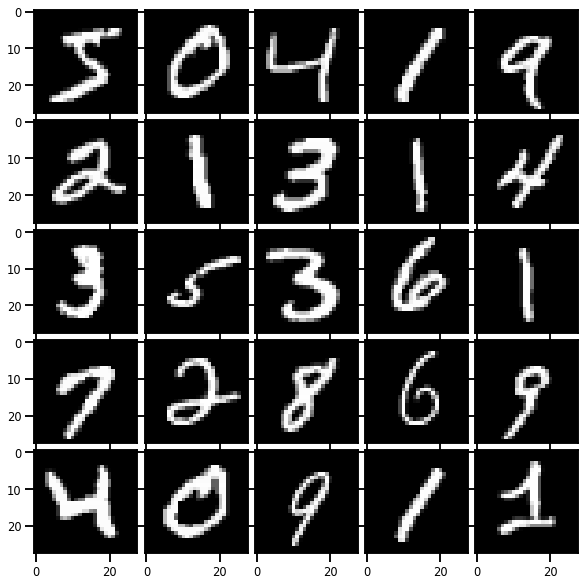

In [4]:
# plot batch of images

fig, ax = plot_image_grid(X_init)
plt.show()

### Preprocessing Steps

1. Dequantize the variables

Basically add some uniform noise to help with training.

2. Normalize the pixels

We constrain the pixels to be from $[0, 256)$ to $[0, 1)$.

In [5]:
from typing import Optional, Mapping
from chex import Array
from einops import rearrange

PRNGKey = Array
Batch = Mapping[str, np.ndarray]


def prepare_data(batch: Batch, prng_key: Optional[PRNGKey] = None) -> Array:

    # select image from tfds
    data = batch.astype(jnp.float32)

    # (N,H,W)-> (N,C,H,W)
    data = jnp.expand_dims(data, axis=3)

    # dequantize pixels (training only)
    if prng_key is not None:
        # Dequantize pixel values {0, 1, ..., 255} with uniform noise [0, 1).
        data += jax.random.uniform(prng_key, data.shape).astype(jnp.float32)

    # flatten image data
    data = rearrange(data, "B H W C -> B (H W C)")

    return data / 256.0  # Normalize pixel values from [0, 256) to [0, 1).

#### Demo

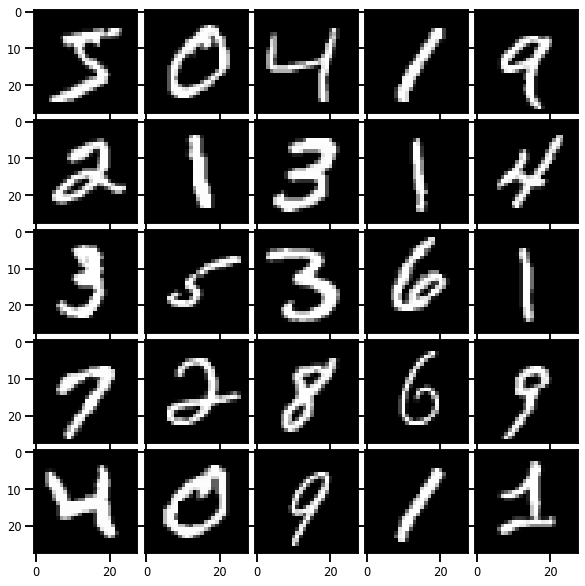

In [6]:
# create key
rng, prng_key = jax.random.split(KEY, num=2)

# prep the data
X_init_prepped = prepare_data(X_init, prng_key=prng_key)

# plot image grid
fig, ax = plot_image_grid(X_init_prepped, image_shape)

## Model

### Initialize Data

In [18]:
model = "mixture"

In [19]:
n_reflections = 10
init_rotation = "random"

# nn params
n_blocks = 6
image_shape = ImageShape(C=1, H=28, W=28)
filters = [(2, 2), (4, 4), (7, 7,), (14, 14)]

In [20]:
if model == "splines":
    from rbig_jax.models.gaussflow import init_gf_spline_model

    # marginal uniformization
    n_bins = 8
    range_min = -12
    range_max = 12
    boundary_slopes = "unconstrained"
    identity_init = False

    plot_layers = False
    plot_blocks = False

elif model == "mixture":
    from rbig_jax.models.gaussflow import init_default_gf_model

    mixture = "gaussian"
    inverse_cdf = "gaussian"
    init_mixcdf = "gmm"
    n_components = 10
else:
    raise ValueError(f"Unrecognized Model: {model}")

In [21]:
if model == "splines":
    from rbig_jax.models.multiscale import init_multiscale_flow_spline

    # init model
    X_g, gf_model = init_multiscale_flow_spline(
        seed=42,
        image_shape=image_shape,
        filters=filters,
        X=X_init_prepped,
        n_blocks=n_blocks,
        n_bins=n_bins,
        range_min=range_min,
        range_max=range_max,
        boundary_slopes=boundary_slopes,
        identity_init=identity_init,
        n_reflections=n_reflections,
        init_rotation=init_rotation,
        return_transform=True,
    )

elif model == "mixture":
    from rbig_jax.models.multiscale import init_multiscale_flow

    # init model
    X_g, gf_model = init_multiscale_flow(
        seed=42,
        image_shape=image_shape,
        filters=filters,
        X=X_init_prepped,
        n_blocks=n_blocks,
        n_components=n_components,
        inverse_cdf=inverse_cdf,
        init_mixcdf=init_mixcdf,
        mixture=mixture,
        n_reflections=n_reflections,
        init_rotation=init_rotation,
        return_transform=True,
    )
else:
    raise ValueError(f"Unrecognized Model: {model}")

Filter: (2, 2) - Layer: 0 - X: (10000, 784)- Initializing MixCDF:   0%|          | 0/4 [00:00<?, ?it/s]
  0%|          | 0/6 [00:00<?, ?it/s]
Initializing - Block: 1 | Layer 0:   0%|          | 0/6 [00:00<?, ?it/s]
Initializing - Block: 1 | Layer 1:   0%|          | 0/6 [01:23<?, ?it/s]
Initializing - Block: 1 | Layer 2:   0%|          | 0/6 [01:24<?, ?it/s]
Initializing - Block: 1 | Layer 2:  17%|█▋        | 1/6 [01:24<07:02, 84.60s/it]
Initializing - Block: 2 | Layer 3:  17%|█▋        | 1/6 [01:24<07:02, 84.60s/it]
Initializing - Block: 2 | Layer 4:  17%|█▋        | 1/6 [02:58<07:02, 84.60s/it]
Initializing - Block: 2 | Layer 5:  17%|█▋        | 1/6 [02:59<07:02, 84.60s/it]
Initializing - Block: 2 | Layer 5:  33%|███▎      | 2/6 [02:59<06:02, 90.72s/it]
Initializing - Block: 3 | Layer 6:  33%|███▎      | 2/6 [02:59<06:02, 90.72s/it]
Initializing - Block: 3 | Layer 7:  33%|███▎      | 2/6 [04:38<06:02, 90.72s/it]
Initializing - Block: 3 | Layer 8:  33%|███▎      | 2/6 [04:39<06:02, 90

### Demo Transformation

#### Forward

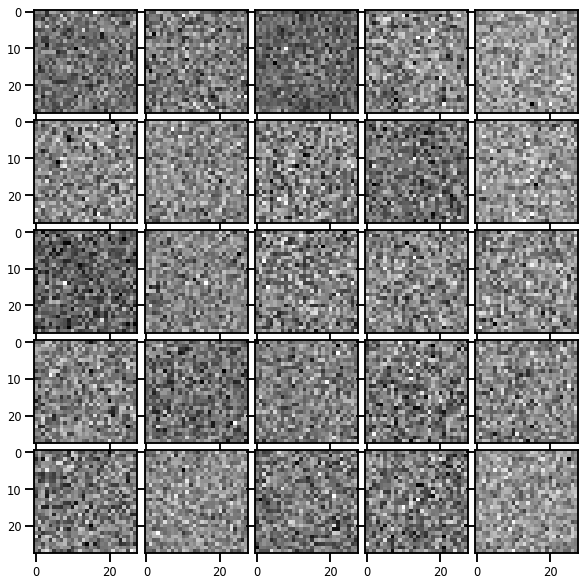

In [23]:
# plot demo images
# plot image grid
fig, ax = plot_image_grid(X_g, image_shape)

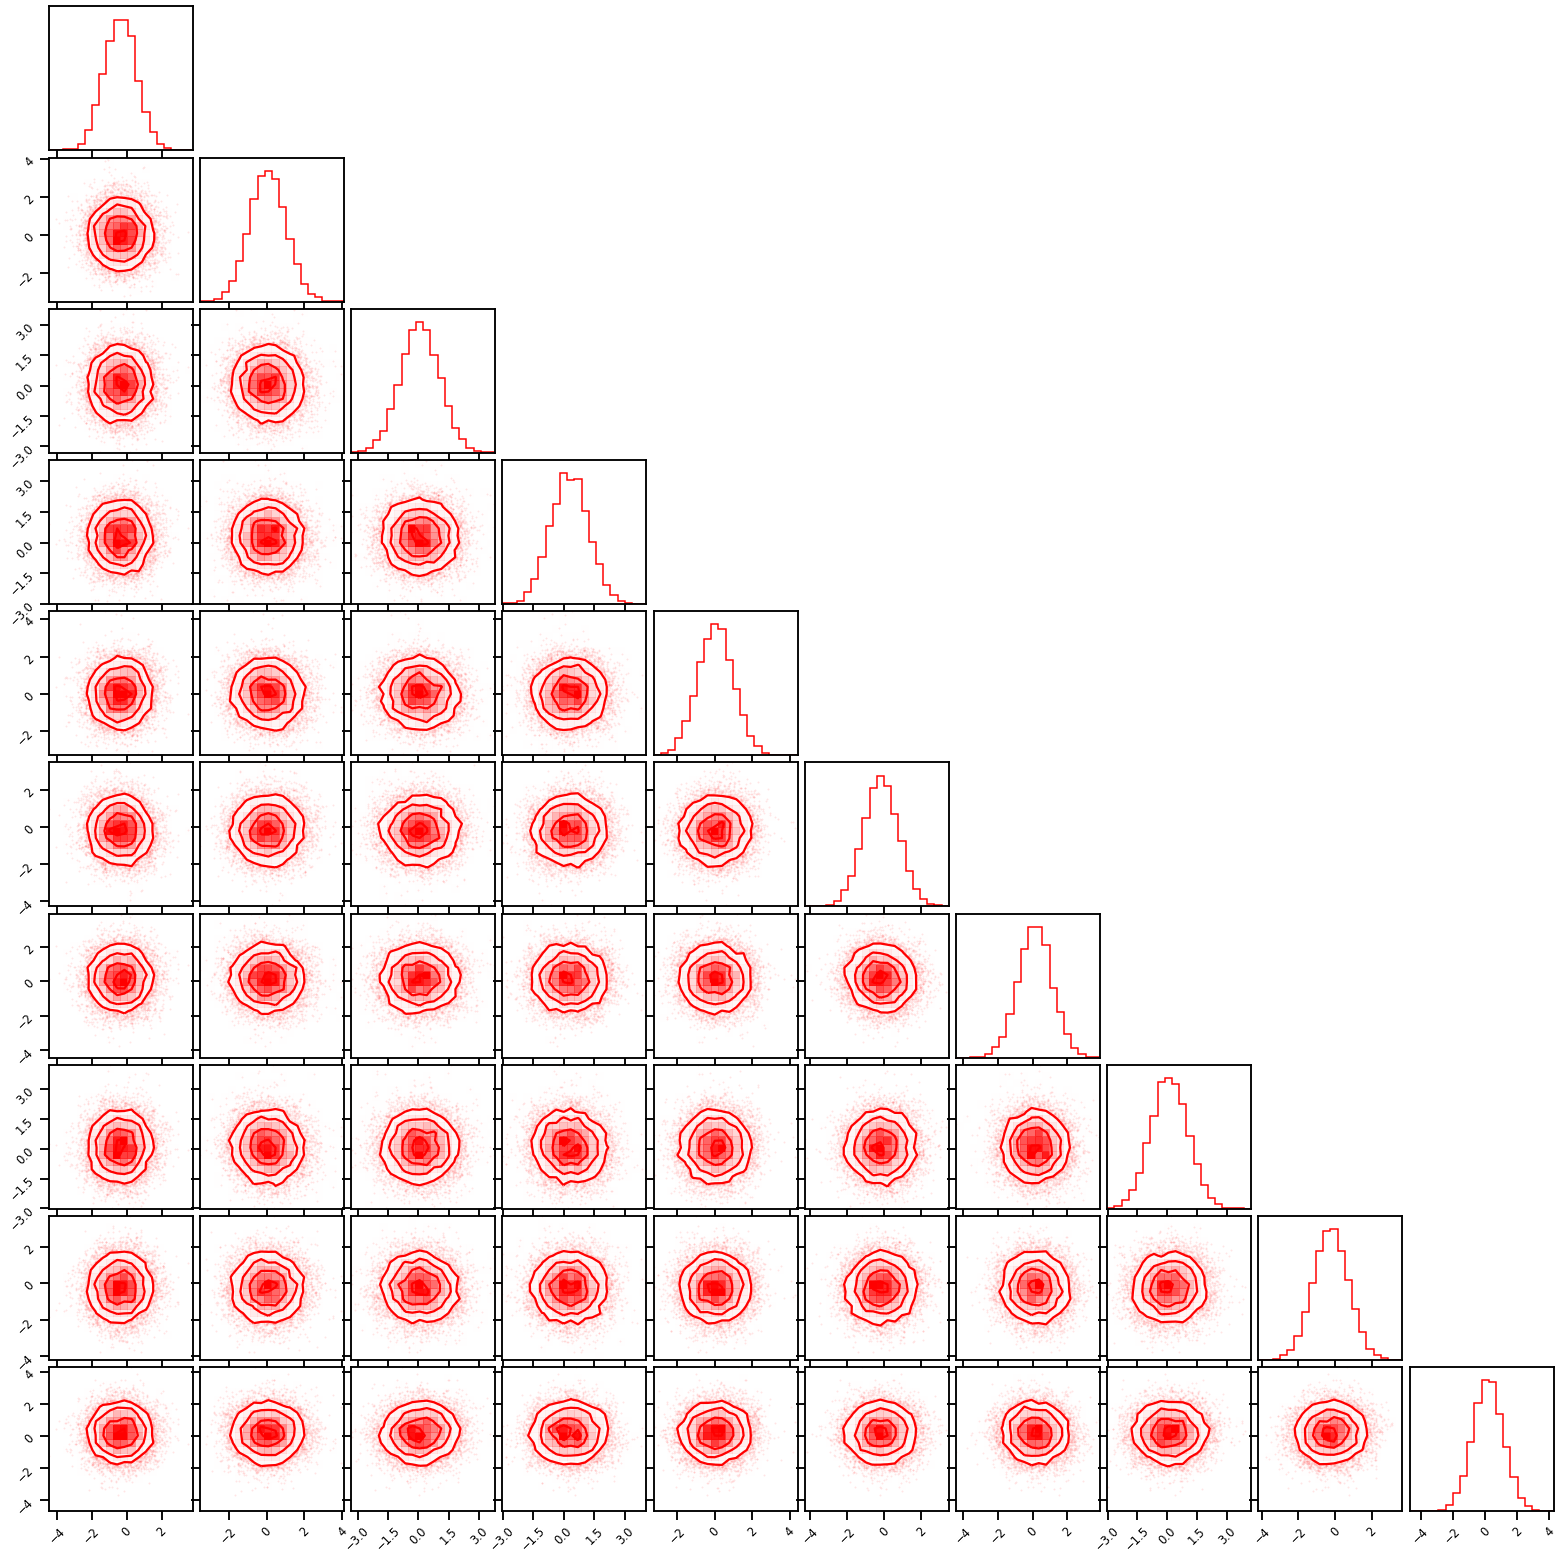

In [24]:
fig = corner.corner(np.array(X_g[:, :10]), color="red")

### Initial Score

#### Negative Log-Likelihood

In [27]:
%%time


init_nll_score = gf_model.score(X_init_prepped[:64])

print(f"NLL", init_nll_score)

NLL -3231.9712
CPU times: user 16.1 s, sys: 308 ms, total: 16.4 s
Wall time: 13 s


#### NLL - Bits per Dimension

In [28]:
from rbig_jax.losses import nll_2_bpd

# jit the loss
nll_2_bpd = jax.jit(nll_2_bpd)

init_nll_score_bpd = nll_2_bpd(init_nll_score, image_shape)

print(f"NLL (bits-per-dim)", init_nll_score_bpd)

NLL (bits-per-dim) -5.947384


#### Inverse

In [29]:
%%time

# forward propagation for data
X_demo_approx = gf_model.inverse(X_g[:25])

CPU times: user 7min 57s, sys: 39.6 s, total: 8min 37s
Wall time: 1min 41s


(<Figure size 720x720 with 50 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x7fb5080285e0>)

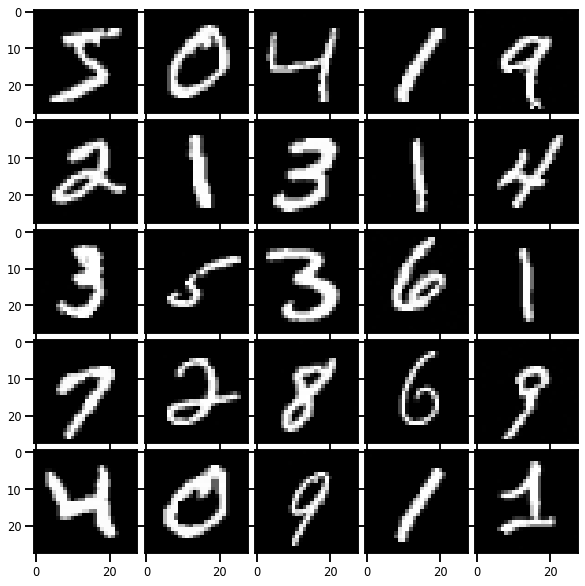

In [30]:
# plot demo images
plot_image_grid(X_demo_approx, image_shape)

### Loss Function

We're going to minimize the log probability

In [51]:
from rbig_jax.training.parametric import init_optimizer

n_epochs = 5_000
# initialize optimizer
optimizer = init_optimizer(
    "adam", lr=1e-3, cosine_decay_steps=n_epochs, gradient_norm_clip=1.0, alpha=1e-1,
)

### NF Trainer

In [52]:
from rbig_jax.training.parametric import GaussFlowTrainer

# initial flow trainer
nf_trainer = GaussFlowTrainer(
    gf_model, optimizer, n_epochs=n_epochs, prepare_data_fn=prepare_data
)

### DataLoaders

In [53]:
import tensorflow_datasets as tfds
from typing import Iterator, Mapping
from sklearn import datasets
import numpy as np
import tensorflow as tf

Batch = Mapping[str, np.ndarray]

In [54]:
def load_dataset(split: str = "train", batch_size: int = 123) -> Iterator[Batch]:
    (X_train, _), (X_test) = tf.keras.datasets.mnist.load_data()
    if split == "train":
        ds = tf.data.Dataset.from_tensor_slices((X_train))
    elif split == "test":
        ds = tf.data.Dataset.from_tensor_slices((X_test))
    else:
        raise ValueError(f"Unrecognized split")

    ds = ds.shuffle(buffer_size=10 * batch_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    ds = ds.repeat()
    return iter(tfds.as_numpy(ds))

In [55]:
train_batch_size = 64
valid_batch_size = 1_000

train_ds = load_dataset("train", train_batch_size)
valid_ds = load_dataset("test", valid_batch_size)

In [56]:
# number of epochs
# epochs = 250
eval_frequency = 50
# split the keys into a unique subset
train_rng = jax.random.split(rng, num=n_epochs)

# create an iterator
train_rng = iter(train_rng)

### Train Loop

In [58]:
# %%wandb

import tqdm

eval_loss = 0.0
eval_frequency = 50
with tqdm.trange(n_epochs) as pbar:
    for step in pbar:

        # Train Step
        output = nf_trainer.train_step(next(train_ds), rng=next(train_rng))
        train_loss = output.loss
        train_loss = nll_2_bpd(train_loss, image_shape)
        pbar.set_description(
            f"Train Loss: {train_loss:.4f} | Valid Loss: {eval_loss:.4f}"
        )

        # Eval Step
        if step % eval_frequency == 0:
            output = nf_trainer.validation_step(next(valid_ds))
            eval_loss = output.loss
            eval_loss = nll_2_bpd(eval_loss, X_init.shape[1:])
            pbar.set_description(
                f"Train Loss: {train_loss:.4f} | Valid Loss: {eval_loss:.4f}"
            )

gf_model = output.model

Train Loss: 49.1164 | Valid Loss: 0.0000:   0%|          | 0/5000 [00:01<?, ?it/s]


AttributeError: 'tuple' object has no attribute 'astype'

## Results

In [ ]:
fig, ax = plt.subplots()
ax.plot(
    nf_trainer.train_epoch, nf_trainer.train_loss, label="Training Loss", color="blue"
)
ax.plot(
    nf_trainer.valid_epoch,
    nf_trainer.valid_loss,
    label="Validation Loss",
    color="orange",
)
ax.set(
    xlabel="Iterations", ylabel="Negative Log-Likelihood",
)
plt.legend()
plt.tight_layout()
plt.show()

CPU times: user 26.4 s, sys: 3.34 s, total: 29.7 s
Wall time: 9.98 s


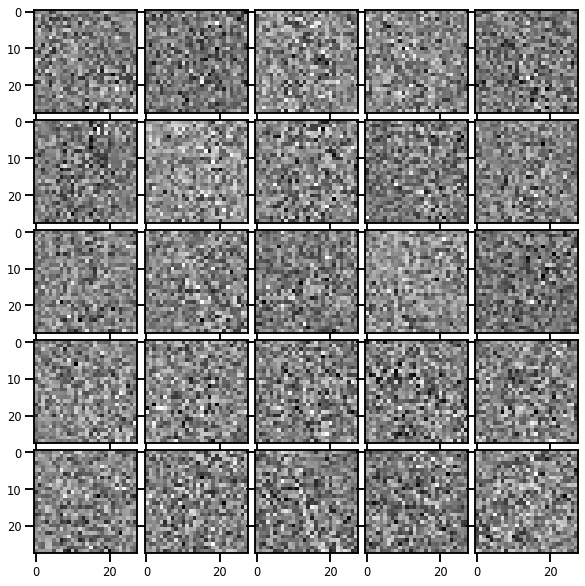

In [23]:
%%time

# forward propagation for data
X_demo_g = gf_model.forward(X_init)

# plot demo images
# plot image grid
fig, ax = plot_image_grid(X_demo_g, image_shape)


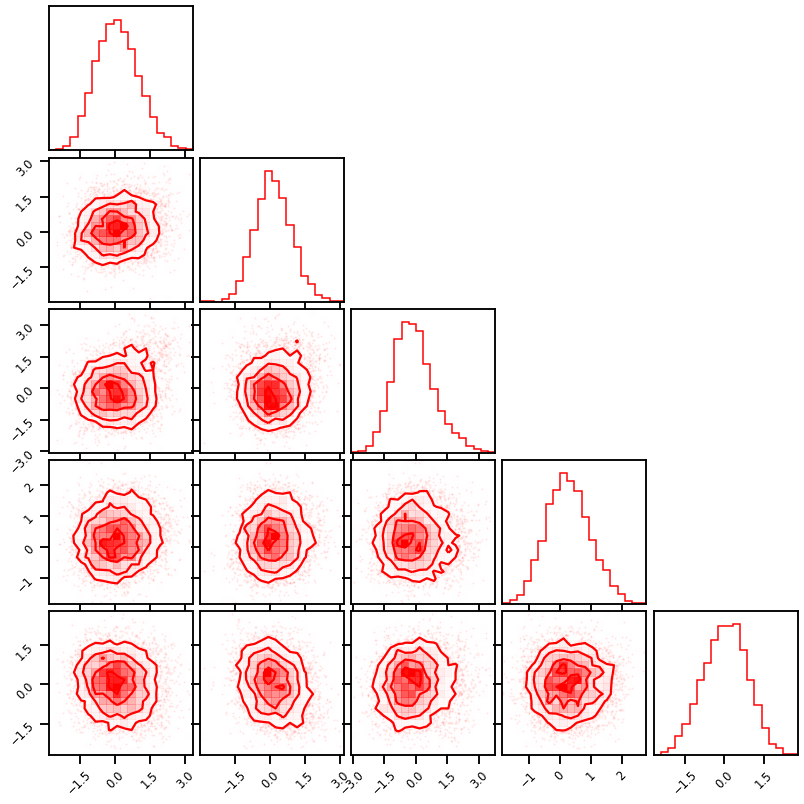

In [24]:
fig = corner.corner(np.array(X_demo_g[:, :5]), color="red")
wandb.log({"final_latent_histogram": wandb.Image(plt)})

CPU times: user 27.2 s, sys: 3.04 s, total: 30.3 s
Wall time: 9.82 s


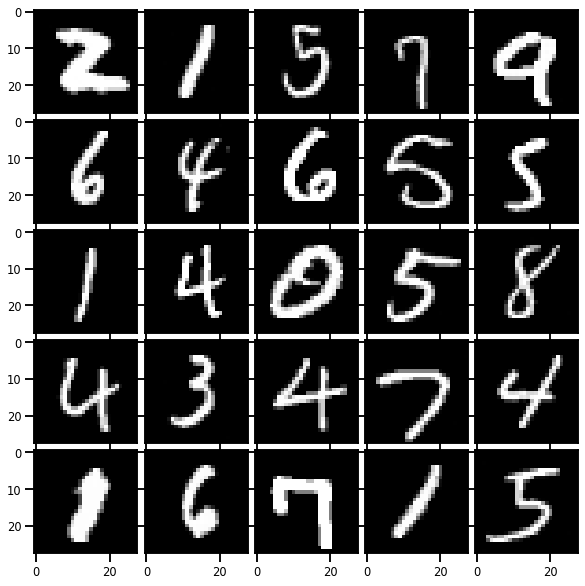

In [25]:
%%time

# forward propagation for data
X_demo_approx = gf_model.inverse(X_demo_g)

# plot demo images
# plot image grid
fig, ax = plot_image_grid(X_demo_approx, image_shape)
# plot image grid

### Sampling

CPU times: user 53.5 s, sys: 7.44 s, total: 1min
Wall time: 18.6 s


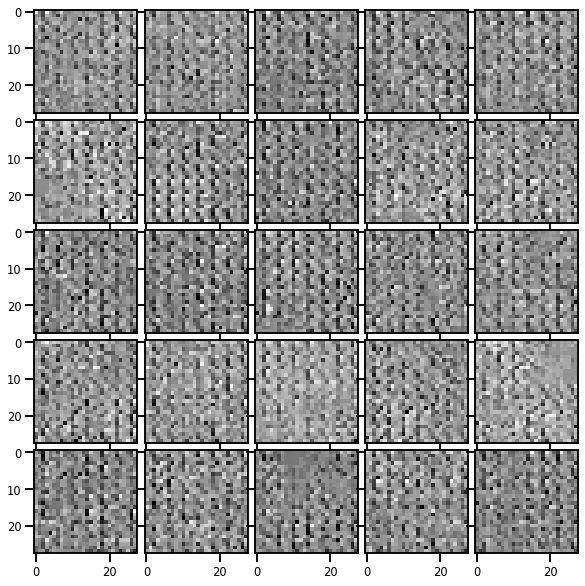

In [27]:
%%time

# X_g_samples = jax.random.randn((5_000, 784))
n_gen_samples = 10_000
X_samples = gf_model.sample(seed=123, n_samples=n_gen_samples)

# plot
fig, ax = plot_image_grid(X_samples, image_shape)

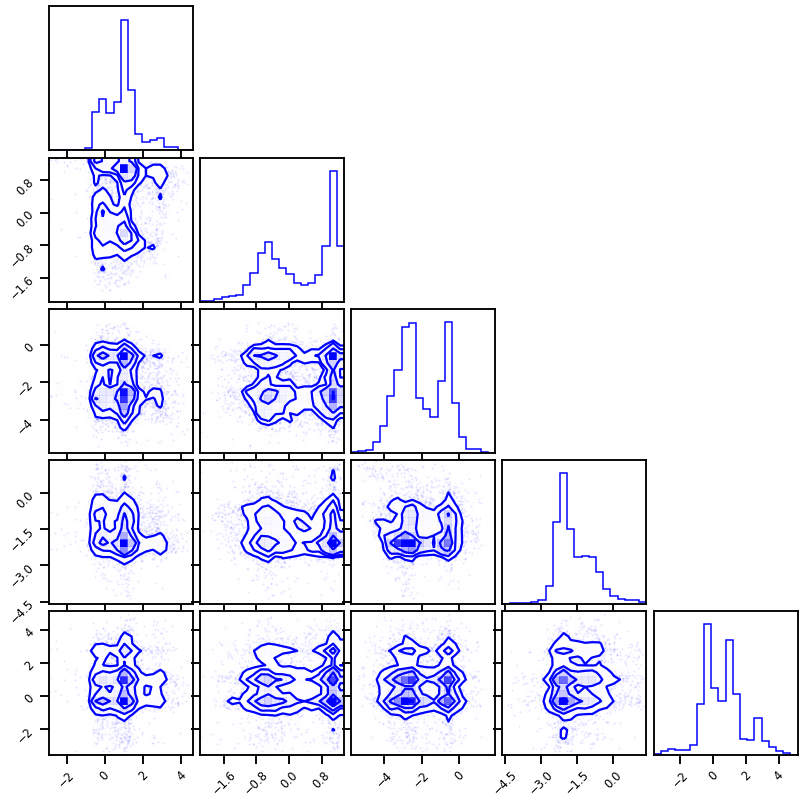

In [53]:
fig = corner.corner(np.array(X_samples[:, :5]), color="Blue")

In [57]:

X_g = X_init.copy()[:50]

fig = corner.corner(X_g, color="purple")
fig.suptitle("Initial")
plt.show()

for ilayer, ibijector in enumerate(gf_model.bijectors):
    
    X_g = ibijector.forward(X_g)
    
    if (ilayer+1) % 3 == 0:
        fig = corner.corner(X_g[:,:5], color="purple")
        fig.suptitle(f"Block: {(ilayer+1)//3}")
        plt.show()
        
        break
        
    
    

Error in callback <function _WandbInit._resume_backend at 0x7f0d6061f790> (for pre_run_cell):


Exception: The wandb backend process has shutdown

AssertionError: I don't believe that you want more dimensions than samples!

Error in callback <function _WandbInit._pause_backend at 0x7f0d6061f310> (for post_run_cell):


Exception: The wandb backend process has shutdown

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 198, in check_status
    status_response = self._interface.communicate_stop_status()
  File "/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/wandb/sdk/interface/interface.py", line 735, in communicate_stop_status
    resp = self._communicate(req, timeout=timeout, local=True)
  File "/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/wandb/sdk/interface/interface.py", line 537, in _communicate
    return self._communicate_async(rec, local=local).get(timeout=timeout)
  File "/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/wandb/sd

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X_g[:, 0], X_g[:, 1], s=3)
ax.set_aspect('equal', 'box')
plt.tight_layout()

## Saving/Loading Model

In [101]:
import joblib

#### Save Model

In [102]:
model_save_name = os.path.join(wandb.run.dir, "gf_model.pckl")
joblib.dump(gf_model, model_save_name)
wandb.save(model_save_name)

['gf_model_mnist.pickle']

#### Load Model

In [103]:
gf_model_ = joblib.load(model_save_name)